# Instacart Market Basket Analysis Exploratory Data Analysis

### By Philip Sparks

## Objective: Use Instacart's grocery order data to determine statistically valid and actionable insights for a hypothetical email marketing campaign.

### Import the neccessary modules for data manipulation and visual representation

In [1]:

%matplotlib inline
from warnings import filterwarnings
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import sklearn as sk
import scipy
import keras
import featuretools

Using TensorFlow backend.


#### From GitHub, these descriptions will help with wrangling the data into the correct format for discovery and analysis.

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

### Convert all tables to the Pandas Data Frames we will eventually be working with.



In [2]:
aisles = pd.DataFrame.from_csv('instacart_2017_05_01/aisles.csv')

departments = pd.DataFrame.from_csv('instacart_2017_05_01/departments.csv')

order_products__priors = pd.DataFrame.from_csv('instacart_2017_05_01/order_products__prior.csv')

order_products__train = pd.DataFrame.from_csv('instacart_2017_05_01/order_products__train.csv')

orders = pd.DataFrame.from_csv('instacart_2017_05_01/orders.csv')

products = pd.DataFrame.from_csv('instacart_2017_05_01/products.csv')

### Check the heads of the data to see samples and confirm data is loaded.

In [3]:
aisles.head()

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation


In [4]:
departments.head(25)

,department
department_id,
1,frozen
2,other
3,bakery
4,produce
5,alcohol
6,international
7,beverages
8,pets
9,dry goods pasta


In [5]:
order_products__priors.head(10)

,product_id,add_to_cart_order,reordered
order_id,,,
2,33120,1,1
2,28985,2,1
2,9327,3,0
2,45918,4,1
2,30035,5,0
2,17794,6,1
2,40141,7,1
2,1819,8,1
2,43668,9,0


In [6]:
order_products__train.head(10)

,product_id,add_to_cart_order,reordered
order_id,,,
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0
1,47209,7,0
1,22035,8,1
36,39612,1,0


In [7]:
orders.sort_index().head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1,112108,train,4,4,10,9.0
2,202279,prior,3,5,9,8.0
3,205970,prior,16,5,17,12.0
4,178520,prior,36,1,9,7.0
5,156122,prior,42,6,16,9.0


In [8]:
products.head(15)

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13
6,Dry Nose Oil,11,11
7,Pure Coconut Water With Orange,98,7
8,Cut Russet Potatoes Steam N' Mash,116,1
9,Light Strawberry Blueberry Yogurt,120,16


### Check for null values.

In [9]:
print aisles.isnull().any()
print departments.isnull().any()
print orders.isnull().any()
print products.isnull().any()

aisle    False
dtype: bool
department    False
dtype: bool
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool
product_name     False
aisle_id         False
department_id    False
dtype: bool


### Determine the same with the product orders.

In [10]:
print order_products__priors.isnull().any()
print order_products__train.isnull().any()

product_id           False
add_to_cart_order    False
reordered            False
dtype: bool
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool


### orders : days_since_prior_order has NaN. We'll change that to "0" to have numerical values throughout the set.

In [11]:
orders.fillna(value = 0).head(5)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
2539329,1,prior,1,2,8,0.0
2398795,1,prior,2,3,7,15.0
473747,1,prior,3,3,12,21.0
2254736,1,prior,4,4,7,29.0
431534,1,prior,5,4,15,28.0


In [12]:
print orders.isnull().any()

user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool


### Append training and prior sets to create a data frame with all rows for merging.

In [13]:
orders_products_full = order_products__priors.append(order_products__train)

In [14]:
orders.sort_index().head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,
1,112108,train,4,4,10,9.0
2,202279,prior,3,5,9,8.0
3,205970,prior,16,5,17,12.0
4,178520,prior,36,1,9,7.0
5,156122,prior,42,6,16,9.0


In [15]:
orders_products_full.sort_index().head()

,product_id,add_to_cart_order,reordered
order_id,,,
1,49302,1,1
1,10246,3,0
1,49683,4,0
1,43633,5,1
1,13176,6,0


### Merge the data frames into one for future EDA and analysis.

In [16]:
orders_join_1 = pd.merge(orders, orders_products_full, left_index = True, right_index = True, how = 'left')

In [17]:
orders_join_1.head()

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
order_id,,,,,,,,,
1,112108,train,4,4,10,9.0,49302.0,1.0,1.0
1,112108,train,4,4,10,9.0,11109.0,2.0,1.0
1,112108,train,4,4,10,9.0,10246.0,3.0,0.0
1,112108,train,4,4,10,9.0,49683.0,4.0,0.0
1,112108,train,4,4,10,9.0,43633.0,5.0,1.0


In [18]:
orders_join_2 = pd.merge(orders_join_1, products, left_on = 'product_id', right_index = True, how = 'left')

In [19]:
orders_join_2.head(5)

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
order_id,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120.0,16.0
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108.0,16.0
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83.0,4.0
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83.0,4.0
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95.0,15.0


In [20]:
aisles.head(20)

,aisle
aisle_id,
1,prepared soups salads
2,specialty cheeses
3,energy granola bars
4,instant foods
5,marinades meat preparation
6,other
7,packaged meat
8,bakery desserts
9,pasta sauce


In [21]:
orders_final = pd.merge(orders_join_2, aisles, left_on = 'aisle_id', right_index = True, how = 'left')

In [22]:
orders_final

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120,16.0,yogurt
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16.0,other creams cheeses
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95,15.0,canned meat seafood
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,47209,7.0,0.0,Organic Hass Avocado,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,22035,8.0,1.0,Organic Whole String Cheese,21,16.0,packaged cheese
2,202279,prior,3,5,9,8.0,33120,1.0,1.0,Organic Egg Whites,86,16.0,eggs


### Truncate orders final to create faster run times in future analysis

In [23]:
orders_final_short = orders_final[:100000]
orders_final_short.shape

(100000, 13)

## Exploring the Data Frame

### 1. Most Purchased Items on Instacart

In [24]:
orders_final.product_name.value_counts().head()

Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Name: product_name, dtype: int64

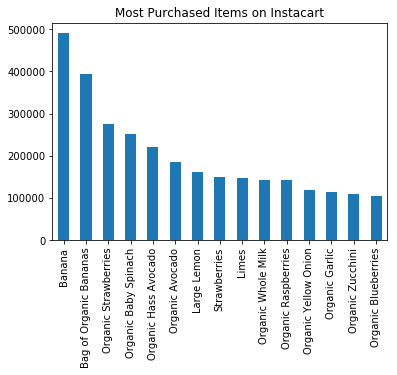

In [25]:
orders_final.product_name.value_counts().head(15).plot(kind = 'bar', title = 'Most Purchased Items on Instacart')

### 2. Orders sorted by Day of the Week

In [26]:
orders_final.order_dow.value_counts().sort_index()

0    6549360
1    5882935
2    4387546
3    4007383
4    3951864
5    4396423
6    4718595
Name: order_dow, dtype: int64

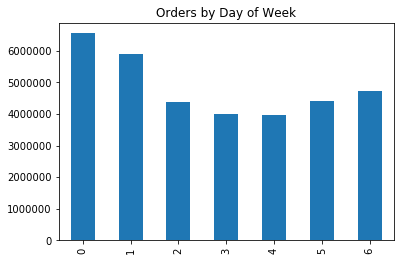

In [27]:
orders_final.order_dow.value_counts().sort_index().plot(kind = 'bar', title = 'Orders by Day of Week')

### 3. Orders sorted by Hour of the Day

In [28]:
orders_final.order_hour_of_day.value_counts().sort_index()

0      228565
1      121707
2       72824
3       53890
4       55848
5       92104
6      303258
7      930075
8     1790896
9     2555852
10    2880853
11    2858813
12    2738612
13    2784168
14    2817301
15    2787163
16    2653804
17    2191771
18    1718801
19    1320804
20    1020163
21     832806
22     663539
23     420489
Name: order_hour_of_day, dtype: int64

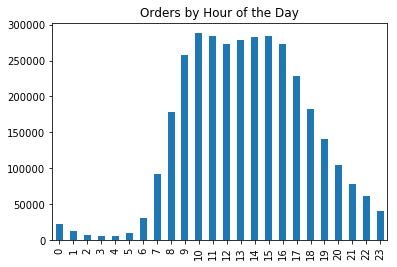

In [29]:
orders.order_hour_of_day.value_counts().sort_index().plot(kind = 'bar', title = 'Orders by Hour of the Day')

### 4. Orders sorted by Days since a previous Order

In [30]:
orders.days_since_prior_order.value_counts().sort_index()

0.0      67755
1.0     145247
2.0     193206
3.0     217005
4.0     221696
5.0     214503
6.0     240013
7.0     320608
8.0     181717
9.0     118188
10.0     95186
11.0     80970
12.0     76146
13.0     83214
14.0    100230
15.0     66579
16.0     46941
17.0     39245
18.0     35881
19.0     34384
20.0     38527
21.0     45470
22.0     32012
23.0     23885
24.0     20712
25.0     19234
26.0     19016
27.0     22013
28.0     26777
29.0     19191
30.0    369323
Name: days_since_prior_order, dtype: int64

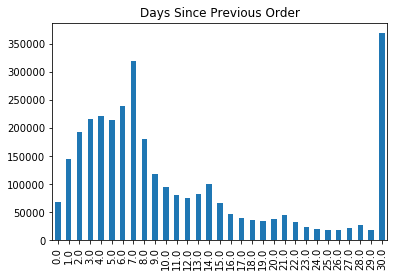

In [31]:
orders.days_since_prior_order.value_counts().sort_index().plot(kind = 'bar', title = 'Days Since Previous Order')

### 5. First Order versus Reorder Count

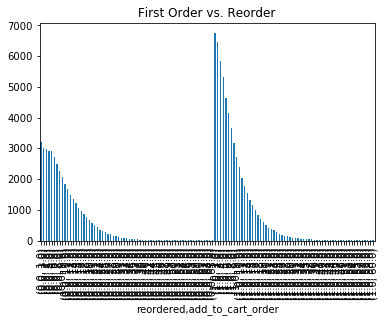

In [32]:
orders_final_short.groupby('reordered')['add_to_cart_order'].value_counts().plot(kind = 'bar', title = 'First Order vs. Reorder')

### 6. Order Number Threshold

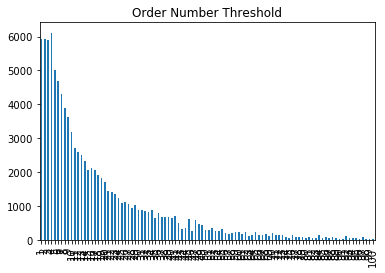

In [33]:
orders_final_short.order_number.value_counts().sort_index().plot(kind = 'bar',title = 'Order Number Threshold',)

## Statistical Trends

### Correlation Matrix of Variables Given to Each Order

,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,department_id
user_id,1.000000,-0.014424,0.015628,-0.003005,0.008079,-0.003047,-0.004030,-0.004934
order_number,-0.014424,1.000000,-0.006661,-0.066339,-0.354977,-0.008702,0.305353,0.003803
order_dow,0.015628,-0.006661,1.000000,0.016943,-0.032119,-0.018849,-0.011434,0.008317
order_hour_of_day,-0.003005,-0.066339,0.016943,1.000000,0.023035,-0.004438,-0.026904,-0.013685
days_since_prior_order,0.008079,-0.354977,-0.032119,0.023035,1.000000,0.042469,-0.143491,0.001652
add_to_cart_order,-0.003047,-0.008702,-0.018849,-0.004438,0.042469,1.000000,-0.132798,0.034106
reordered,-0.004030,0.305353,-0.011434,-0.026904,-0.143491,-0.132798,1.000000,-0.041061
department_id,-0.004934,0.003803,0.008317,-0.013685,0.001652,0.034106,-0.041061,1.000000


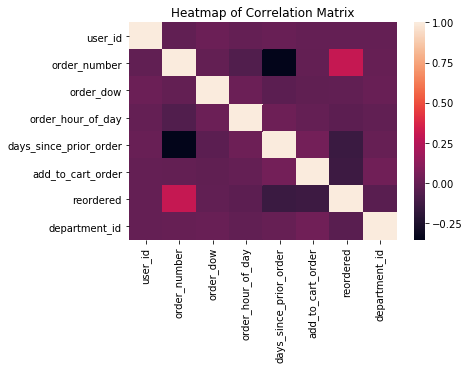

In [34]:
heat_corr = orders_final_short.corr()
heat_corr = (heat_corr)

sns.heatmap(heat_corr, 
            xticklabels= heat_corr.columns.values,
            yticklabels= heat_corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
heat_corr

### None of the variables given in the data set show a strong visual correlation to one another.

## Small versus Large Order Size: Is there a difference in those types of orders?

### Show description to determine where the small and large bins should be split (at orders 5 and 24, respectively.

In [35]:
orders_final_short.order_number.describe()

count    100000.000000
mean         17.313450
std          17.577222
min           1.000000
25%           5.000000
50%          11.000000
75%          24.000000
max         100.000000
Name: order_number, dtype: float64

In [36]:
small_nums = [1,2,3,4,5]
small = orders_final_short[orders_final_short['order_number'].isin(small_nums)]
small

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
1,112108,train,4,4,10,9.0,49302,1.0,1.0,Bulgarian Yogurt,120,16.0,yogurt
1,112108,train,4,4,10,9.0,11109,2.0,1.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16.0,other creams cheeses
1,112108,train,4,4,10,9.0,10246,3.0,0.0,Organic Celery Hearts,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,49683,4.0,0.0,Cucumber Kirby,83,4.0,fresh vegetables
1,112108,train,4,4,10,9.0,43633,5.0,1.0,Lightly Smoked Sardines in Olive Oil,95,15.0,canned meat seafood
1,112108,train,4,4,10,9.0,13176,6.0,0.0,Bag of Organic Bananas,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,47209,7.0,0.0,Organic Hass Avocado,24,4.0,fresh fruits
1,112108,train,4,4,10,9.0,22035,8.0,1.0,Organic Whole String Cheese,21,16.0,packaged cheese
2,202279,prior,3,5,9,8.0,33120,1.0,1.0,Organic Egg Whites,86,16.0,eggs


In [37]:
large_nums = list(range(24,100))
large = orders_final_short[orders_final_short['order_number'].isin(large_nums)]
large

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
order_id,,,,,,,,,,,,,
4,178520,prior,36,1,9,7.0,46842,1.0,0.0,Plain Pre-Sliced Bagels,93,3.0,breakfast bakery
4,178520,prior,36,1,9,7.0,26434,2.0,1.0,Honey/Lemon Cough Drops,11,11.0,cold flu allergy
4,178520,prior,36,1,9,7.0,39758,3.0,1.0,Chewy 25% Low Sugar Chocolate Chip Granola,3,19.0,energy granola bars
4,178520,prior,36,1,9,7.0,27761,4.0,1.0,Oats & Chocolate Chewy Bars,48,14.0,breakfast bars pastries
4,178520,prior,36,1,9,7.0,10054,5.0,1.0,Kellogg's Nutri-Grain Apple Cinnamon Cereal,48,14.0,breakfast bars pastries
4,178520,prior,36,1,9,7.0,21351,6.0,1.0,Nutri-Grain Soft Baked Strawberry Cereal Break...,48,14.0,breakfast bars pastries
4,178520,prior,36,1,9,7.0,22598,7.0,1.0,Kellogg's Nutri-Grain Blueberry Cereal,48,14.0,breakfast bars pastries
4,178520,prior,36,1,9,7.0,34862,8.0,1.0,Tiny Twists Pretzels,107,19.0,chips pretzels
4,178520,prior,36,1,9,7.0,40285,9.0,1.0,Traditional Snack Mix,125,19.0,trail mix snack mix


In [38]:
large_vs_small = pd.concat([large, small], ignore_index=True)
large_vs_small

,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,178520,prior,36,1,9,7.0,46842,1.0,0.0,Plain Pre-Sliced Bagels,93,3.0,breakfast bakery
1,178520,prior,36,1,9,7.0,26434,2.0,1.0,Honey/Lemon Cough Drops,11,11.0,cold flu allergy
2,178520,prior,36,1,9,7.0,39758,3.0,1.0,Chewy 25% Low Sugar Chocolate Chip Granola,3,19.0,energy granola bars
3,178520,prior,36,1,9,7.0,27761,4.0,1.0,Oats & Chocolate Chewy Bars,48,14.0,breakfast bars pastries
4,178520,prior,36,1,9,7.0,10054,5.0,1.0,Kellogg's Nutri-Grain Apple Cinnamon Cereal,48,14.0,breakfast bars pastries
5,178520,prior,36,1,9,7.0,21351,6.0,1.0,Nutri-Grain Soft Baked Strawberry Cereal Break...,48,14.0,breakfast bars pastries
6,178520,prior,36,1,9,7.0,22598,7.0,1.0,Kellogg's Nutri-Grain Blueberry Cereal,48,14.0,breakfast bars pastries
7,178520,prior,36,1,9,7.0,34862,8.0,1.0,Tiny Twists Pretzels,107,19.0,chips pretzels
8,178520,prior,36,1,9,7.0,40285,9.0,1.0,Traditional Snack Mix,125,19.0,trail mix snack mix
9,178520,prior,36,1,9,7.0,17616,10.0,1.0,Goldfish Cheddar Baked Snack Crackers,78,19.0,crackers


### Gather sample mean and standard deviation for hypothesis testing.

In [39]:
orders_final_short_std = orders_final_short['days_since_prior_order'].std()
orders_final_short_mean = orders_final_short['days_since_prior_order'].mean()
print 'Sample Mean: {}, Sample STD: {}'.format(orders_final_short_mean, orders_final_short_std)

Sample Mean: 11.2007867319, Sample STD: 8.78218546303


In [40]:
small_mean = small['days_since_prior_order'].mean()
print('Small mean is: ', small_mean)
large_mean = large['days_since_prior_order'].mean()
print('Large mean is: ', large_mean)

small_std = small['days_since_prior_order'].std()
print('Small standard deviation is: ', small_std)
large_std = large['days_since_prior_order'].std()
print('Large standard deviation is: ', large_std)

('Small mean is: ', 14.873703477730324)
('Large mean is: ', 6.7400992047870245)
('Small standard deviation is: ', 9.895624370464294)
('Large standard deviation is: ', 5.41265954854452)


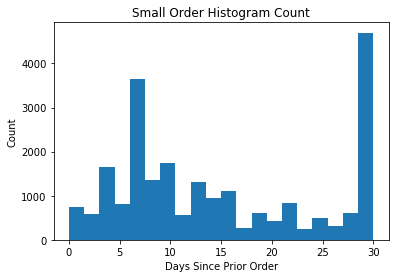

In [41]:
plt.hist(small.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.title('Small Order Histogram Count')

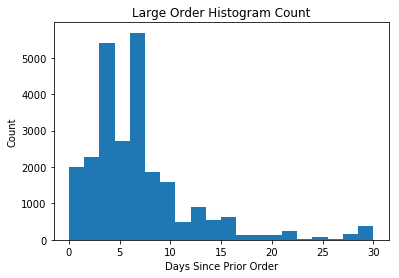

In [42]:
plt.hist(large.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.title('Large Order Histogram Count')

In [44]:
difference_mean = small_mean - large_mean
print('Mean difference between two populations: ', difference_mean)
difference_sem = np.sqrt(large_std**2/len(large) + small_std**2/len(small))
print( 'Standard error of the mean: ', difference_sem)

('Mean difference between two populations: ', 8.133604272943298)
('Standard error of the mean: ', 0.067404186158317822)


In [45]:
z_score_difference = (difference_mean - 0)/difference_sem
z_score_difference

120.66912660052337

In [46]:
p_value_difference = 1-scipy.stats.norm.cdf(z_score_difference)
p_value_difference * 100

0.0

### There is a significant difference between the population of users who are in the bottom quartile versus those who are at the top in number of orders purchased. Large basket users return about eight days sooner than small basket purchasers.

## Break down the data into 10 percentile brackets

In [47]:
orders_10 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0, 0.1]))]
orders_20 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.1, 0.2]))]
orders_30 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.2, 0.3]))]
orders_40 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.3, 0.4]))]
orders_50 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.4, 0.5]))]
orders_60 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.5, 0.6]))]
orders_70 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.6, 0.7]))]
orders_80 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.7, 0.8]))]
orders_90 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.8, 0.9]))]
orders_100 = orders_final_short[orders_final_short.order_number.between(*orders_final_short.order_number.quantile([0.9, 1]))]

In [48]:
orders_final.product_name.value_counts(1).head(25)

Banana                        0.014527
Bag of Organic Bananas        0.011678
Organic Strawberries          0.008149
Organic Baby Spinach          0.007443
Organic Hass Avocado          0.006531
Organic Avocado               0.005447
Large Lemon                   0.004754
Strawberries                  0.004419
Limes                         0.004337
Organic Whole Milk            0.004223
Organic Raspberries           0.004217
Organic Yellow Onion          0.003481
Organic Garlic                0.003369
Organic Zucchini              0.003235
Organic Blueberries           0.003106
Cucumber Kirby                0.002949
Organic Fuji Apple            0.002747
Organic Lemon                 0.002698
Organic Grape Tomatoes        0.002604
Apple Honeycrisp Organic      0.002581
Seedless Red Grapes           0.002565
Organic Cucumber              0.002514
Honeycrisp Apple              0.002464
Organic Baby Carrots          0.002380
Sparkling Water Grapefruit    0.002343
Name: product_name, dtype

In [49]:
orders_10.product_name.value_counts().head(5)

Banana                    163
Bag of Organic Bananas    120
Organic Strawberries       97
Organic Avocado            84
Organic Baby Spinach       84
Name: product_name, dtype: int64

In [50]:
orders_20.product_name.value_counts().head(5)

Banana                    250
Bag of Organic Bananas    187
Organic Strawberries      130
Organic Baby Spinach      121
Organic Avocado           110
Name: product_name, dtype: int64

In [51]:
orders_30.product_name.value_counts().head(5)

Banana                    218
Bag of Organic Bananas    165
Organic Strawberries      125
Organic Avocado           113
Organic Baby Spinach      106
Name: product_name, dtype: int64

In [52]:
orders_40.product_name.value_counts().head(5)

Banana                    192
Bag of Organic Bananas    134
Organic Strawberries      101
Organic Baby Spinach       95
Organic Hass Avocado       76
Name: product_name, dtype: int64

In [53]:
orders_50.product_name.value_counts().head(5)

Banana                    215
Bag of Organic Bananas    117
Organic Baby Spinach      114
Organic Strawberries      108
Organic Hass Avocado       78
Name: product_name, dtype: int64

In [54]:
orders_60.product_name.value_counts().head(5)

Banana                    178
Bag of Organic Bananas    152
Organic Strawberries      113
Organic Baby Spinach       96
Organic Hass Avocado       89
Name: product_name, dtype: int64

In [55]:
orders_70.product_name.value_counts().head(5)

Banana                    157
Bag of Organic Bananas    135
Organic Baby Spinach       87
Organic Hass Avocado       83
Organic Strawberries       78
Name: product_name, dtype: int64

In [56]:
orders_80.product_name.value_counts().head(5)

Banana                    187
Bag of Organic Bananas    157
Organic Baby Spinach       92
Organic Strawberries       85
Organic Hass Avocado       77
Name: product_name, dtype: int64

In [57]:
orders_90.product_name.value_counts().head(5)

Bag of Organic Bananas    162
Banana                    157
Organic Strawberries       89
Organic Baby Spinach       78
Organic Hass Avocado       72
Name: product_name, dtype: int64

In [58]:
orders_100.product_name.value_counts().head(5)

Bag of Organic Bananas    183
Banana                    155
Organic Strawberries       98
Organic Raspberries        84
Organic Hass Avocado       83
Name: product_name, dtype: int64

In [59]:
print('10th percentile mean is: ', orders_10['order_number'].mean())
print('20th percentile mean is: ', orders_20['order_number'].mean())
print('30th percentile mean is: ', orders_30['order_number'].mean())
print('40th percentile mean is: ', orders_40['order_number'].mean())
print('50th percentile mean is: ', orders_50['order_number'].mean())
print('60th percentile mean is: ', orders_60['order_number'].mean())
print('70th percentile mean is: ', orders_70['order_number'].mean())
print('80th percentile mean is: ', orders_80['order_number'].mean())
print('90th percentile mean is: ', orders_90['order_number'].mean())
print('100th percentile mean is: ', orders_100['order_number'].mean())

('10th percentile mean is: ', 1.499536607970343)
('20th percentile mean is: ', 3.010425377710877)
('30th percentile mean is: ', 4.909832437559279)
('40th percentile mean is: ', 6.9379508260296285)
('50th percentile mean is: ', 9.351055104019089)
('60th percentile mean is: ', 12.873277559055119)
('70th percentile mean is: ', 17.380609797875984)
('80th percentile mean is: ', 23.557536180727144)
('90th percentile mean is: ', 33.9557409758752)
('100th percentile mean is: ', 57.67427170736306)


### No significant differences in products purchased based on how many orders were made by quintile..

#### Also, Cannot really discern if there's a significant difference in population based on what top products they ordered.

## Reorders versus New Purchases

In [60]:
reordered = orders_final_short[orders_final_short['reordered'] == 1]
not_reordered = orders_final_short[orders_final_short['reordered'] == 0]

In [61]:
reordered_mean = reordered['days_since_prior_order'].mean()
print('Reordered mean is: ', reordered_mean)
not_reordered_mean = not_reordered['days_since_prior_order'].mean()
print('Not Reordered mean is: ', not_reordered_mean)

reordered_std = reordered['days_since_prior_order'].std()
print('Reordered standard deviation is: ', reordered_std)
not_reordered_std = not_reordered['days_since_prior_order'].std()
print('Not reordered standard deviation is: ', not_reordered_std)

('Reordered mean is: ', 10.229017150173524)
('Not Reordered mean is: ', 12.840441559946688)
('Reordered standard deviation is: ', 8.083897996891537)
('Not reordered standard deviation is: ', 9.63008376714549)


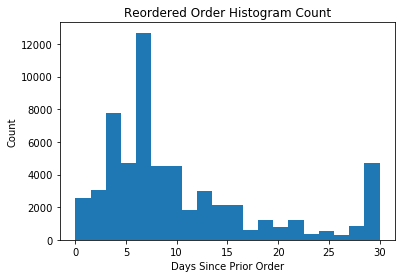

In [62]:
plt.hist(reordered.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.title('Reordered Order Histogram Count')

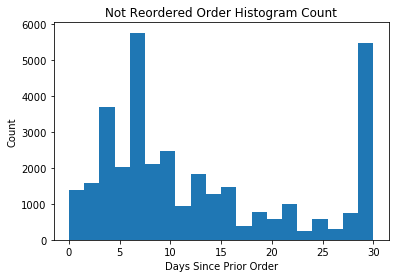

In [63]:
plt.hist(not_reordered.days_since_prior_order.dropna(), bins = 20)
plt.xlabel('Days Since Prior Order')
plt.ylabel('Count')
plt.title('Not Reordered Order Histogram Count')

In [64]:
difference_mean_1 = (reordered_mean - not_reordered_mean) * (-1)
print('Mean difference between two populations: ', difference_mean_1)
difference_sem_1 = np.sqrt(not_reordered_std**2/len(not_reordered) + reordered_std**2/len(reordered))
print( 'Standard error of the mean: ', difference_sem_1)

('Mean difference between two populations: ', 2.6114244097731643)
('Standard error of the mean: ', 0.058252728720742941)


In [65]:
z_score_difference_1 = (difference_mean_1 - 0)/difference_sem_1
z_score_difference_1

44.829220315018041

In [66]:
p_value_difference_1 = 1-scipy.stats.norm.cdf(z_score_difference_1)
p_value_difference_1 * 100

0.0

### A statistically significant difference is found between new order purchasers and reorder purchasers.
### The mean difference in populations is about 2.61 days less since prior order for the reordered populations.
### Conclusion: People who are reordering are returning faster than those who are making new first purchase.

## Order Thresholds

In [67]:
orders.order_number.value_counts().sort_index()

1      206209
2      206209
3      206209
4      206209
5      182223
6      162633
7      146468
8      132618
9      120918
10     110728
11     101696
12      93881
13      86929
14      80693
15      75080
16      69889
17      65296
18      61157
19      57321
20      53931
21      50731
22      47810
23      45104
24      42499
25      40211
26      38025
27      35965
28      34057
29      32278
30      30677
        ...  
71       4235
72       4081
73       3915
74       3777
75       3615
76       3453
77       3319
78       3199
79       3072
80       2945
81       2829
82       2721
83       2602
84       2516
85       2417
86       2317
87       2224
88       2146
89       2067
90       1990
91       1905
92       1849
93       1780
94       1713
95       1656
96       1592
97       1525
98       1471
99       1421
100      1374
Name: order_number, Length: 100, dtype: int64

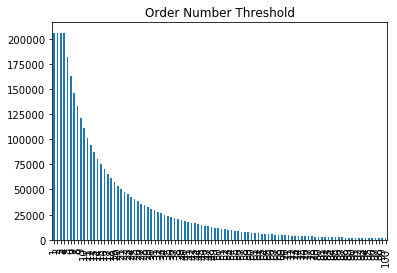

In [68]:
orders.order_number.value_counts().sort_index().plot(kind = 'bar',title = 'Order Number Threshold')

### After a 12% drop-off from the fourth to fifth items, largely due to an artifact of the dataset, there is a linear 5% drop-off in successive orders from the entirety of the dataset.

In [69]:
n = max(orders['order_number'])
for i in range(n):
    threshold_percent = round((orders['order_number'] == i).sum() / (orders['order_number'] == (i-1)).sum() * 100, 2)
    print 'The precentage of orders that were retained from order number {} to order number {} was {}%.'.format(i-1, i, threshold_percent)

The precentage of orders that were retained from order number -1 to order number 0 was nan%.
The precentage of orders that were retained from order number 0 to order number 1 was inf%.
The precentage of orders that were retained from order number 1 to order number 2 was 100.0%.
The precentage of orders that were retained from order number 2 to order number 3 was 100.0%.
The precentage of orders that were retained from order number 3 to order number 4 was 100.0%.
The precentage of orders that were retained from order number 4 to order number 5 was 88.37%.
The precentage of orders that were retained from order number 5 to order number 6 was 89.25%.
The precentage of orders that were retained from order number 6 to order number 7 was 90.06%.
The precentage of orders that were retained from order number 7 to order number 8 was 90.54%.
The precentage of orders that were retained from order number 8 to order number 9 was 91.18%.
The precentage of orders that were retained from order number 9

The precentage of orders that were retained from order number 86 to order number 87 was 95.99%.
The precentage of orders that were retained from order number 87 to order number 88 was 96.49%.
The precentage of orders that were retained from order number 88 to order number 89 was 96.32%.
The precentage of orders that were retained from order number 89 to order number 90 was 96.27%.
The precentage of orders that were retained from order number 90 to order number 91 was 95.73%.
The precentage of orders that were retained from order number 91 to order number 92 was 97.06%.
The precentage of orders that were retained from order number 92 to order number 93 was 96.27%.
The precentage of orders that were retained from order number 93 to order number 94 was 96.24%.
The precentage of orders that were retained from order number 94 to order number 95 was 96.67%.
The precentage of orders that were retained from order number 95 to order number 96 was 96.14%.
The precentage of orders that were retai

## Small Threshold
### There is a 20% drop off in the fourth to fifth purchase (where 4 is the min value of items purchased)

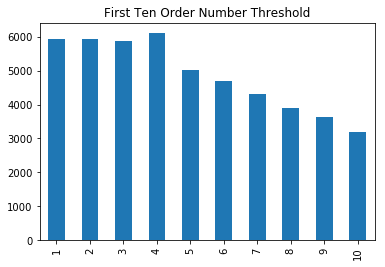

In [70]:
ten_nums = [1,2,3,4,5,6,7,8,9,10]
first_10 = orders_final_short[orders_final_short['order_number'].isin(ten_nums)]
first_10
first_10.order_number.value_counts().sort_index().plot(kind = 'bar',title = 'First Ten Order Number Threshold',)

In [71]:
n = max(first_10['order_number'])
for i in range(n):
    threshold_percent = round((first_10['order_number'] == i).sum() / (first_10['order_number'] == (i-1)).sum() * 100, 2)
    print 'The precentage of orders that were retained from order number {} to order number {} was {}%.'.format(i-1, i, threshold_percent)

The precentage of orders that were retained from order number -1 to order number 0 was nan%.
The precentage of orders that were retained from order number 0 to order number 1 was inf%.
The precentage of orders that were retained from order number 1 to order number 2 was 99.81%.
The precentage of orders that were retained from order number 2 to order number 3 was 99.38%.
The precentage of orders that were retained from order number 3 to order number 4 was 103.8%.
The precentage of orders that were retained from order number 4 to order number 5 was 81.9%.
The precentage of orders that were retained from order number 5 to order number 6 was 93.63%.
The precentage of orders that were retained from order number 6 to order number 7 was 91.96%.
The precentage of orders that were retained from order number 7 to order number 8 was 90.19%.
The precentage of orders that were retained from order number 8 to order number 9 was 93.29%.


## Large Threshold
### At every fifth item, there appears to be a strong drop-off after a near 100% retention. Users may have returned and purchased more items, which creates the above 100% retention rates for some values.

In [72]:
n = max(large['order_number'])
for i in range(n):
    threshold_percent = round((large['order_number'] == i).sum() / (large['order_number'] == (i-1)).sum() * 100, 2)
    print 'The precentage of orders that were retained from order number {} to order number {} was {}%.'.format(i-1, i, threshold_percent)

The precentage of orders that were retained from order number -1 to order number 0 was nan%.
The precentage of orders that were retained from order number 0 to order number 1 was nan%.
The precentage of orders that were retained from order number 1 to order number 2 was nan%.
The precentage of orders that were retained from order number 2 to order number 3 was nan%.
The precentage of orders that were retained from order number 3 to order number 4 was nan%.
The precentage of orders that were retained from order number 4 to order number 5 was nan%.
The precentage of orders that were retained from order number 5 to order number 6 was nan%.
The precentage of orders that were retained from order number 6 to order number 7 was nan%.
The precentage of orders that were retained from order number 7 to order number 8 was nan%.
The precentage of orders that were retained from order number 8 to order number 9 was nan%.
The precentage of orders that were retained from order number 9 to order number

The precentage of orders that were retained from order number 90 to order number 91 was 121.43%.
The precentage of orders that were retained from order number 91 to order number 92 was 305.88%.
The precentage of orders that were retained from order number 92 to order number 93 was 47.12%.
The precentage of orders that were retained from order number 93 to order number 94 was 120.41%.
The precentage of orders that were retained from order number 94 to order number 95 was 59.32%.
The precentage of orders that were retained from order number 95 to order number 96 was 74.29%.
The precentage of orders that were retained from order number 96 to order number 97 was 257.69%.
The precentage of orders that were retained from order number 97 to order number 98 was 23.88%.


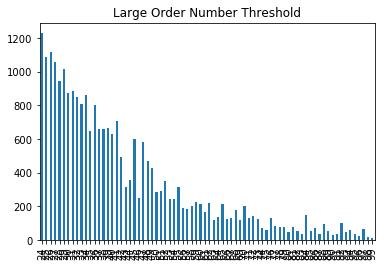

In [73]:
large.order_number.value_counts().sort_index().plot(kind = 'bar',title = 'Large Order Number Threshold',)

## Normalization of the Order Contents

### Overall normalization

In [74]:
orders_final_short.product_name.value_counts(1).head(25)

Banana                        0.014868
Bag of Organic Bananas        0.011962
Organic Strawberries          0.007975
Organic Baby Spinach          0.007254
Organic Hass Avocado          0.006432
Organic Avocado               0.005520
Strawberries                  0.004629
Large Lemon                   0.004599
Organic Raspberries           0.004288
Limes                         0.004128
Organic Whole Milk            0.003827
Organic Yellow Onion          0.003627
Organic Garlic                0.003356
Organic Zucchini              0.002956
Organic Lemon                 0.002785
Organic Blueberries           0.002775
Cucumber Kirby                0.002775
Organic Fuji Apple            0.002775
Organic Grape Tomatoes        0.002705
Honeycrisp Apple              0.002645
Apple Honeycrisp Organic      0.002625
Organic Cucumber              0.002465
Organic Half & Half           0.002455
Sparkling Water Grapefruit    0.002425
Organic Baby Arugula          0.002364
Name: product_name, dtype

### Small Normalized Values

In [75]:
small.product_name.value_counts(1).head(25)

Banana                               0.014244
Bag of Organic Bananas               0.010189
Organic Strawberries                 0.007659
Organic Baby Spinach                 0.006793
Organic Avocado                      0.006758
Organic Hass Avocado                 0.005684
Strawberries                         0.004644
Large Lemon                          0.004436
Limes                                0.004124
Organic Garlic                       0.003431
Organic Baby Arugula                 0.003154
Organic Blueberries                  0.003154
Organic Raspberries                  0.003154
Organic Yellow Onion                 0.002876
Cucumber Kirby                       0.002842
Organic Whole Milk                   0.002842
Organic Zucchini                     0.002807
Organic Fuji Apple                   0.002495
Yellow Onions                        0.002495
Honeycrisp Apple                     0.002461
Organic Lemon                        0.002218
Organic Grape Tomatoes            

### Large Normalized Values
#### Notice how "Organic Whole Milk" has almost doubled it's basket percentage value from 0.002842 to 0.004968
#### Nominally, milk jumps from #16th to #8th.

In [76]:
large.product_name.value_counts(1).head(25)

Bag of Organic Bananas                  0.015535
Banana                                  0.015259
Organic Strawberries                    0.008438
Organic Hass Avocado                    0.007097
Organic Baby Spinach                    0.006861
Organic Raspberries                     0.006664
Strawberries                            0.005323
Organic Whole Milk                      0.004968
Organic Avocado                         0.004968
Large Lemon                             0.004810
Organic Yellow Onion                    0.004258
Limes                                   0.004179
Organic Garlic                          0.003588
Organic Fuji Apple                      0.003351
Organic Zucchini                        0.003273
Organic Large Extra Fancy Fuji Apple    0.003273
Organic Lemon                           0.003273
Organic Grape Tomatoes                  0.003233
Apple Honeycrisp Organic                0.003194
Organic Gala Apples                     0.003115
Seedless Red Grapes 

### Normalized from first ten orders for each user

In [77]:
first_10.product_name.value_counts(1).head(25)

Banana                      0.014824
Bag of Organic Bananas      0.009855
Organic Strawberries        0.007731
Organic Baby Spinach        0.007195
Organic Avocado             0.005958
Organic Hass Avocado        0.005793
Strawberries                0.004391
Large Lemon                 0.004350
Limes                       0.003773
Organic Raspberries         0.003361
Organic Yellow Onion        0.003216
Organic Blueberries         0.003154
Organic Garlic              0.003072
Cucumber Kirby              0.003031
Organic Whole Milk          0.002990
Organic Zucchini            0.002742
Honeycrisp Apple            0.002721
Organic Baby Arugula        0.002701
Yellow Onions               0.002515
Organic Lemon               0.002495
Organic Fuji Apple          0.002474
Organic Grape Tomatoes      0.002453
Apple Honeycrisp Organic    0.002206
Organic Half & Half         0.002165
Fresh Cauliflower           0.002103
Name: product_name, dtype: float64

## Summary of Insights Gathered

### 1. There is a significant difference between the population of users who are in the bottom quartile versus those who are at the top in number of orders purchased. The mean difference in populations is about 8.13 days less since prior order between large (>75% percentile) basket orders and small (< 25% percentile) orders. In other words, people who are purchasing large orders of goods are being retained much higher than users who are making small purchases.

### 2.  A statistically significant difference is found between new order purchasers and reorder purchasers. The mean difference in populations is about 2.61 days less  since prior order for the reordered populations.
### Conclusion: People who are reordering are returning faster than those who are making new first purchase.

### 3. Small order Threshold: There is a 20% drop off in the fourth to fifth purchase (where 4 is the minimum value of items purchased).

### 4. "Organic Whole Milk" almost doubled its basket percentage value from 0.002842 to 0.004968 from the small to large basket orders.Nominally, milk jumps from #16 to #8.

### 5. Does not seem be any significant differences in products purchased based on how many orders were made by quintile.

### 6. Data insight not shown: Cannot really discern if there is a significant difference in population based on what top three or four products they ordered.

### Note for recommendation: Offer incentive for users to come back right after first purchase in order to have regression data on user.